In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, mean_absolute_error

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter


In [2]:
filesList = os.listdir('../src')
print(filesList)

['soil_data.csv', 'train_timeseries', 'counties.geojson', 'test_timeseries', 'validation_timeseries', 'counties.zip']


In [3]:
# dataDic = {"train": pd.read_csv("../src/train_timeseries/train_timeseries.csv"),
#            "test": pd.read_csv("../src/test_timeseries/test_timeseries.csv"),
#            "validation": pd.read_csv("../src/validation_timeseries/validation_timeseries.csv"),
#            "soil" : pd.read_csv("../src/soil_data.csv"),
#            }

In [4]:
# dataDic["train"].columns

In [5]:
class2id = {
    'None': 0,
    'D0': 1,
    'D1': 2,
    'D2': 3,
    'D3': 4,
    'D4': 5,
}
id2class = {v: k for k, v in class2id.items()}

In [6]:
# dfs = {
#     k: dataDic[k].set_index(['fips', 'date'])
#     for k in dataDic.keys() if k != "soil"
# }

# dfs["soil"] = dataDic["soil"]

In [7]:
batch_size = 128
output_weeks = 6
use_static = True
hidden_dim = 512
n_layers = 2
ffnn_layers = 2
dropout = 0.1
one_cycle = True
lr = 9e-5
epochs = 15
clip = 5


In [8]:
def interpolate_nans(padata, pkind='linear'):
    """
    see: https://stackoverflow.com/a/53050216/2167159
    """
    aindexes = np.arange(padata.shape[0])
    agood_indexes, = np.where(np.isfinite(padata))
    f = interp1d(agood_indexes
               , padata[agood_indexes]
               , bounds_error=False
               , copy=False
               , fill_value="extrapolate"
               , kind=pkind)
    return f(aindexes)

In [9]:
def date_encode(date):
    if isinstance(date, str):
        date = datetime.strptime(date, "%Y-%m-%d")
    return (
        np.sin(2 * np.pi * date.timetuple().tm_yday / 366),
        np.cos(2 * np.pi * date.timetuple().tm_yday / 366),
    )

In [10]:
def loadXY(
    df,
    random_state=42,
    window_size=180, # how many days in the past (default/competition: 180)
    target_size=6, # how many weeks into the future (default/competition: 6)
    fuse_past=True, # add the past drought observations? (default: True)
    return_fips=False, # return the county identifier (do not use for predictions)
    encode_season=True, # encode the season using the function above (default: True) 
    use_prev_year=False, # add observations from 1 year prior?
):
    df = dfs[df]
    soil_df = dfs["soil"]
    time_data_cols = sorted(
        [c for c in df.columns if c not in ["fips", "date", "score"]]
    )
    static_data_cols = sorted(
        [c for c in soil_df.columns if c not in ["soil", "lat", "lon"]]
    )
    count = 0
    score_df = df.dropna(subset=["score"])
    X_static = np.empty((len(df) // window_size, len(static_data_cols)))
    X_fips_date = []
    add_dim = 0
    if use_prev_year:
        add_dim += len(time_data_cols)
    if fuse_past:
        add_dim += 1
        if use_prev_year:
            add_dim += 1
    if encode_season:
        add_dim += 2
    X_time = np.empty(
        (len(df) // window_size, window_size, len(time_data_cols) + add_dim)
    )
    y_past = np.empty((len(df) // window_size, window_size))
    y_target = np.empty((len(df) // window_size, target_size))
    if random_state is not None:
        np.random.seed(random_state)
    for fips in tqdm(score_df.index.get_level_values(0).unique()):
        if random_state is not None:
            start_i = np.random.randint(1, window_size)
        else:
            start_i = 1
        fips_df = df[(df.index.get_level_values(0) == fips)]
        X = fips_df[time_data_cols].values
        y = fips_df["score"].values
        X_s = soil_df[soil_df["fips"] == fips][static_data_cols].values[0]
        for i in range(start_i, len(y) - (window_size + target_size * 7), window_size):
            X_fips_date.append((fips, fips_df.index[i : i + window_size][-1]))
            X_time[count, :, : len(time_data_cols)] = X[i : i + window_size]
            if use_prev_year:
                if i < 365 or len(X[i - 365 : i + window_size - 365]) < window_size:
                    continue
                X_time[count, :, -len(time_data_cols) :] = X[
                    i - 365 : i + window_size - 365
                ]
            if not fuse_past:
                y_past[count] = interpolate_nans(y[i : i + window_size])
            else:
                X_time[count, :, len(time_data_cols)] = interpolate_nans(
                    y[i : i + window_size]
                )
            if encode_season:
                enc_dates = [
                    date_encode(d) for f, d in fips_df.index[i : i + window_size].values
                ]
                d_sin, d_cos = [s for s, c in enc_dates], [c for s, c in enc_dates]
                X_time[count, :, len(time_data_cols) + (add_dim - 2)] = d_sin
                X_time[count, :, len(time_data_cols) + (add_dim - 2) + 1] = d_cos
            temp_y = y[i + window_size : i + window_size + target_size * 7]
            y_target[count] = np.array(temp_y[~np.isnan(temp_y)][:target_size])
            X_static[count] = X_s
            count += 1
    print(f"loaded {count} samples")
    results = [X_static[:count], X_time[:count], y_target[:count]]
    if not fuse_past:
        results.append(y_past[:count])
    if return_fips:
        results.append(X_fips_date)
    return results

In [11]:
scaler_dict = {}
scaler_dict_static = {}
scaler_dict_past = {}


def normalize(X_static, X_time, y_past=None, fit=False):
    for index in tqdm(range(X_time.shape[-1])):
        if fit:
            scaler_dict[index] = RobustScaler().fit(X_time[:, :, index].reshape(-1, 1))
        X_time[:, :, index] = (
            scaler_dict[index]
            .transform(X_time[:, :, index].reshape(-1, 1))
            .reshape(-1, X_time.shape[-2])
        )
    for index in tqdm(range(X_static.shape[-1])):
        if fit:
            scaler_dict_static[index] = RobustScaler().fit(
                X_static[:, index].reshape(-1, 1)
            )
        X_static[:, index] = (
            scaler_dict_static[index]
            .transform(X_static[:, index].reshape(-1, 1))
            .reshape(1, -1)
        )
    index = 0
    if y_past is not None:
        if fit:
            scaler_dict_past[index] = RobustScaler().fit(y_past.reshape(-1, 1))
        y_past[:, :] = (
            scaler_dict_past[index]
            .transform(y_past.reshape(-1, 1))
            .reshape(-1, y_past.shape[-1])
        )
        return X_static, X_time, y_past
    return X_static, X_time

In [12]:
# X_tabular_train, X_time_train, y_target_train = loadXY("train")
# print("train shape", X_time_train.shape)
# X_tabular_validation, X_time_valid, y_target_valid, valid_fips = loadXY("validation", return_fips=True)
# print("validation shape", X_time_valid.shape)
# X_tabular_train, X_time_train = normalize(X_tabular_train, X_time_train, fit=True)
# X_tabular_validation, X_time_valid = normalize(X_tabular_validation, X_time_valid)

In [13]:
# X_tabular_test, X_time_test, y_target_test, test_fips = loadXY("test", return_fips=True)
# print("test shape", X_time_test.shape)
# X_tabular_test, X_time_test = normalize(X_tabular_test, X_time_test)

In [14]:
# import pickle
# # export all
# np.save("../data/processed_no_cat_and_no_tensors/X_tabular_train.npy", X_tabular_train)
# np.save("../data/processed_no_cat_and_no_tensors/X_time_train.npy", X_time_train)
# np.save("../data/processed_no_cat_and_no_tensors/y_target_train.npy", y_target_train)
# np.save("../data/processed_no_cat_and_no_tensors/X_tabular_validation.npy", X_tabular_validation)
# np.save("../data/processed_no_cat_and_no_tensors/X_time_valid.npy", X_time_valid)
# np.save("../data/processed_no_cat_and_no_tensors/y_target_valid.npy", y_target_valid)
# np.save("../data/processed_no_cat_and_no_tensors/X_tabular_test.npy", X_tabular_test)
# np.save("../data/processed_no_cat_and_no_tensors/X_time_test.npy", X_time_test)
# np.save("../data/processed_no_cat_and_no_tensors/y_target_test.npy", y_target_test)
# with open(f"../data/processed_no_cat_and_no_tensors/valid_fips.pickle", "wb") as f:
#     pickle.dump(valid_fips, f)
# with open(f"../data/processed_no_cat_and_no_tensors/test_fips.pickle", "wb") as f:
#     pickle.dump(test_fips, f)


In [15]:
import pickle
# import all
X_tabular_train = np.load("../data/processed_no_cat_and_no_tensors/X_tabular_train.npy")
X_time_train = np.load("../data/processed_no_cat_and_no_tensors/X_time_train.npy")
y_target_train = np.load("../data/processed_no_cat_and_no_tensors/y_target_train.npy")
X_tabular_validation = np.load("../data/processed_no_cat_and_no_tensors/X_tabular_validation.npy")
X_time_valid = np.load("../data/processed_no_cat_and_no_tensors/X_time_valid.npy")
y_target_valid = np.load("../data/processed_no_cat_and_no_tensors/y_target_valid.npy")
X_tabular_test = np.load("../data/processed_no_cat_and_no_tensors/X_tabular_test.npy")
X_time_test = np.load("../data/processed_no_cat_and_no_tensors/X_time_test.npy")
y_target_test = np.load("../data/processed_no_cat_and_no_tensors/y_target_test.npy")
with open(f"../data/processed_no_cat_and_no_tensors/valid_fips.pickle", "rb") as f:
    valid_fips = pickle.load(f)
with open(f"../data/processed_no_cat_and_no_tensors/test_fips.pickle", "rb") as f:
    test_fips = pickle.load(f)

In [16]:
y_train_tensor = torch.tensor(y_target_train[:, :output_weeks])

# Flatten the target tensor to compute class frequencies
flat_labels = y_train_tensor.view(-1).numpy().round().astype(int)  # Shape: [observations * weeks]
class_counts = np.bincount(flat_labels)  # Count occurrences of each class
class_weights = 1.0 / class_counts       # Inverse of class frequencies

# Map class weights to each [i, j] in the target tensor
weights_per_sample = class_weights[y_train_tensor.numpy().round().astype(int)]  # Shape: [observations, weeks]

# Compute the average weight per observation (averaging over the 6 weeks)
sample_weights = weights_per_sample.mean(axis=1)  # Shape: [observations]

# Create a sampler for the training data
train_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True,
)

# Prepare the datasets
train_data = TensorDataset(
    torch.tensor(X_time_train),
    torch.tensor(X_tabular_train),
    y_train_tensor,
)
valid_data = TensorDataset(
    torch.tensor(X_time_valid),
    torch.tensor(X_tabular_validation),
    torch.tensor(y_target_valid[:, :output_weeks]),
)

# DataLoaders with sampler for training and default for validation
train_loader = DataLoader(
    train_data, batch_size=batch_size, drop_last=False
)

valid_loader = DataLoader(
    valid_data, shuffle=False, batch_size=batch_size, drop_last=False
)

In [17]:
test_data = TensorDataset(
    torch.tensor(X_time_test),
    torch.tensor(X_tabular_test),
    torch.tensor(y_target_test[:, :output_weeks]),
)

test_loader = DataLoader(
    test_data, shuffle=False, batch_size=batch_size, drop_last=False
)

In [18]:
len(train_loader)

759

In [19]:
class HybridModel(nn.Module):
    def __init__(
        self,
        num_numerical_features,
        num_time_series_features,
        hidden_size,
        num_lstm_layers,
        num_fc_tabular_layers,
        num_fc_combined_layers,
        output_size,
        dropout
    ):
        super(HybridModel, self).__init__()
        self.num_lstm_layers = num_lstm_layers
        self.hidden_size = hidden_size

        tabular_fc_layers = []
        for _ in range(num_fc_tabular_layers):
            tabular_fc_layers.append(nn.Linear(num_numerical_features, num_numerical_features))
            tabular_fc_layers.append(nn.ReLU())
        self.tabular_fc_layers = nn.Sequential(
            *tabular_fc_layers, nn.Linear(num_numerical_features, num_numerical_features)
        )

        # TS branch
        self.lstm = nn.LSTM(
            input_size=num_time_series_features,
            hidden_size=hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.attention = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)

        combined_fc_layers = []
        input_dim = num_numerical_features + hidden_size

        for _ in range(num_fc_combined_layers):
            combined_fc_layers.append(nn.Linear(input_dim, hidden_size))
            combined_fc_layers.append(nn.ReLU())
            input_dim = hidden_size
        self.combined_fc_layers = nn.Sequential(
            *combined_fc_layers, nn.Linear(hidden_size, output_size)
        )

    def forward(self, time_series_data, numerical_data):
        batch_size = time_series_data.size(0)
        h0 = torch.zeros(self.num_lstm_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_lstm_layers, batch_size, self.hidden_size).to(device)
        numerical_data = numerical_data.to(torch.float32)
        time_series_data = time_series_data.to(torch.float32)
        x1 = self.tabular_fc_layers(numerical_data)
        # Pass the time series data through the LSTM and the attention mechanism
        lstm_out, _ = self.lstm(time_series_data, (h0, c0))
        attn_weights = F.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attn_weights * lstm_out, dim=1)
        # Pass the data through the attention mechanism
        # context_vector = lstm_out[:, -1, :]  # Last time step output
        x2 = self.dropout(context_vector)
        x = torch.cat((x1, x2), dim=1)
        x = self.combined_fc_layers(x)
        return x

In [20]:
writer = SummaryWriter('../runs/new_attention')

: 

In [ ]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("using GPU")
else:
    device = torch.device("cpu")
    print("using CPU")

model = HybridModel(
    num_numerical_features=X_tabular_train.shape[-1],
    num_time_series_features=X_time_train.shape[-1],
    hidden_size=hidden_dim,
    num_lstm_layers=n_layers,
    num_fc_tabular_layers=ffnn_layers,
    num_fc_combined_layers=2,
    output_size=output_weeks,
    dropout=dropout,
)

model.to(device)
loss_function = nn.MSELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)
counter = 0
valid_loss_min = np.inf
torch.manual_seed(42)
np.random.seed(42)

for i in range(epochs):
    for k, (inputs, static, labels) in tqdm(enumerate(train_loader),
                                            desc=f"epoch {i+1}/{epochs}",
                                            total=len(train_loader),):
        model.train()
        counter += 1
        inputs, labels, static = (
            inputs.to(device),
            labels.to(device),
            static.to(device),
        )
        model.zero_grad()
        output = model(inputs, static)
        loss = loss_function(output, labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            if k == len(train_loader) - 1 or k == (len(train_loader) - 1) // 2:
                val_losses = []
                model.eval()
                labels = []
                preds = []
                raw_labels = []
                raw_preds = []
                for inp, stat, lab in valid_loader:
                    inp, lab, stat = inp.to(device), lab.to(device), stat.to(device)
                    out = model(inp, stat)
                    val_loss = loss_function(out, lab.float())
                    val_losses.append(val_loss.item())
                    for labs in lab:
                        labels.append([int(l.round()) for l in labs])
                        raw_labels.append([float(l) for l in labs])
                    for pred in out:
                        preds.append([int(p.round()) for p in pred])
                        raw_preds.append([float(p) for p in pred])
                # log data
                labels = np.array(labels)
                preds = np.clip(np.array(preds), 0, 5)
                raw_preds = np.array(raw_preds)
                raw_labels = np.array(raw_labels)
                for i in range(output_weeks):
                    log_dict = {
                        "loss": float(loss),
                        "epoch": counter / len(train_loader),
                        "step": counter,
                        "lr": optimizer.param_groups[0]["lr"],
                        "week": i + 1,
                    }
                    # w = f'week_{i+1}_'
                    w = ""
                    log_dict[f"{w}validation_loss"] = np.mean(val_losses)
                    log_dict[f"{w}macro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="macro"
                    )
                    log_dict[f"{w}micro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="micro"
                    )
                    log_dict[f"{w}mae"] = mean_absolute_error(
                        raw_labels[:, i], raw_preds[:, i]
                    )
                    print(log_dict)
                    writer.add_scalars("Loss(Hubber)", {'train': loss,
                                                     'validation': log_dict[f"{w}validation_loss"]},
                                                     counter)
                    writer.add_scalars("F1(MSE)", {'macro': log_dict[f"{w}macro_f1"],
                                                   'micro': log_dict[f"{w}micro_f1"]},
                                                   counter)
                    writer.add_scalar("MAE", log_dict[f"{w}mae"],
                                      counter)
                    writer.add_scalar("Learning-Rate", log_dict["lr"],
                                      counter)
                    for j, f1 in enumerate(
                        f1_score(labels[:, i], preds[:, i], average=None)
                    ):
                        log_dict[f"{w}{id2class[j]}_f1"] = f1
                    model.train()
                if np.mean(val_losses) <= valid_loss_min:
                    torch.save(model.state_dict(), "../models/new_attention.pt")
                    print(
                        "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                            valid_loss_min, np.mean(val_losses)
                        )
                    )
                    valid_loss_min = np.mean(val_losses)

using GPU


epoch 1/15:  50%|█████     | 380/759 [02:14<09:17,  1.47s/it]

{'loss': 1.161827802658081, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 6.213592851873648e-06, 'week': 1, 'validation_loss': np.float64(1.0322076309472323), 'macro_f1': np.float64(0.13810091378625347), 'micro_f1': np.float64(0.7073667073667074), 'mae': np.float64(0.5768601080429714)}
{'loss': 1.161827802658081, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 6.213592851873648e-06, 'week': 2, 'validation_loss': np.float64(1.0322076309472323), 'macro_f1': np.float64(0.1388888888888889), 'micro_f1': np.float64(0.7142857142857143), 'mae': np.float64(0.553192552763539)}
{'loss': 1.161827802658081, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 6.213592851873648e-06, 'week': 3, 'validation_loss': np.float64(1.0322076309472323), 'macro_f1': np.float64(0.1404459098759617), 'micro_f1': np.float64(0.7281237281237282), 'mae': np.float64(0.5417490660066425)}
{'loss': 1.161827802658081, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 6.213592851873648e-06, 'week': 4, 'validation_loss': np.floa

epoch 1/15: 100%|██████████| 759/759 [04:30<00:00,  2.81it/s]


{'loss': 0.7722162008285522, 'epoch': 1.0, 'step': 759, 'lr': 1.3712558305707187e-05, 'week': 1, 'validation_loss': np.float64(0.6616725049912929), 'macro_f1': np.float64(0.3110855777533723), 'micro_f1': np.float64(0.608058608058608), 'mae': np.float64(0.6023957519127092)}
{'loss': 0.7722162008285522, 'epoch': 1.0, 'step': 759, 'lr': 1.3712558305707187e-05, 'week': 2, 'validation_loss': np.float64(0.6616725049912929), 'macro_f1': np.float64(0.3091068126971095), 'micro_f1': np.float64(0.6117216117216118), 'mae': np.float64(0.6071485974526667)}
{'loss': 0.7722162008285522, 'epoch': 1.0, 'step': 759, 'lr': 1.3712558305707187e-05, 'week': 3, 'validation_loss': np.float64(0.6616725049912929), 'macro_f1': np.float64(0.2880473666818892), 'micro_f1': np.float64(0.6105006105006106), 'mae': np.float64(0.6130233500389535)}
{'loss': 0.7722162008285522, 'epoch': 1.0, 'step': 759, 'lr': 1.3712558305707187e-05, 'week': 4, 'validation_loss': np.float64(0.6616725049912929), 'macro_f1': np.float64(0.286

epoch 2/15:  50%|█████     | 380/759 [02:16<09:21,  1.48s/it]

{'loss': 0.5563040971755981, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 2.522869141449812e-05, 'week': 1, 'validation_loss': np.float64(0.5712583772838116), 'macro_f1': np.float64(0.3761259303679798), 'micro_f1': np.float64(0.6227106227106227), 'mae': np.float64(0.5460411940916698)}
{'loss': 0.5563040971755981, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 2.522869141449812e-05, 'week': 2, 'validation_loss': np.float64(0.5712583772838116), 'macro_f1': np.float64(0.3465079476664161), 'micro_f1': np.float64(0.6157916157916158), 'mae': np.float64(0.5575660946667365)}
{'loss': 0.5563040971755981, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 2.522869141449812e-05, 'week': 3, 'validation_loss': np.float64(0.5712583772838116), 'macro_f1': np.float64(0.32348039455975114), 'micro_f1': np.float64(0.6157916157916158), 'mae': np.float64(0.5658052528057974)}
{'loss': 0.5563040971755981, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 2.522869141449812e-05, 'week': 4, 'validation_loss'

epoch 2/15: 100%|██████████| 759/759 [04:32<00:00,  2.79it/s]


{'loss': 0.5936402678489685, 'epoch': 2.0, 'step': 1518, 'lr': 3.931579639475803e-05, 'week': 1, 'validation_loss': np.float64(0.6065677780658006), 'macro_f1': np.float64(0.4210142552106837), 'micro_f1': np.float64(0.5543345543345544), 'mae': np.float64(0.5695866592597485)}
{'loss': 0.5936402678489685, 'epoch': 2.0, 'step': 1518, 'lr': 3.931579639475803e-05, 'week': 2, 'validation_loss': np.float64(0.6065677780658006), 'macro_f1': np.float64(0.39582775421299937), 'micro_f1': np.float64(0.531949531949532), 'mae': np.float64(0.5895400575941663)}
{'loss': 0.5936402678489685, 'epoch': 2.0, 'step': 1518, 'lr': 3.931579639475803e-05, 'week': 3, 'validation_loss': np.float64(0.6065677780658006), 'macro_f1': np.float64(0.39867794275761065), 'micro_f1': np.float64(0.5376475376475377), 'mae': np.float64(0.5941222204682313)}
{'loss': 0.5936402678489685, 'epoch': 2.0, 'step': 1518, 'lr': 3.931579639475803e-05, 'week': 4, 'validation_loss': np.float64(0.6065677780658006), 'macro_f1': np.float64(0.3

epoch 3/15:  50%|█████     | 380/759 [02:16<09:18,  1.47s/it]

{'loss': 0.4747787415981293, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 5.434291570866377e-05, 'week': 1, 'validation_loss': np.float64(0.6640150278806687), 'macro_f1': np.float64(0.3297802802069072), 'micro_f1': np.float64(0.6398046398046398), 'mae': np.float64(0.5257688964734178)}
{'loss': 0.4747787415981293, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 5.434291570866377e-05, 'week': 2, 'validation_loss': np.float64(0.6640150278806687), 'macro_f1': np.float64(0.33498152311097146), 'micro_f1': np.float64(0.6341066341066341), 'mae': np.float64(0.5265552086758927)}
{'loss': 0.4747787415981293, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 5.434291570866377e-05, 'week': 3, 'validation_loss': np.float64(0.6640150278806687), 'macro_f1': np.float64(0.3386025838836541), 'micro_f1': np.float64(0.628001628001628), 'mae': np.float64(0.5296871215560139)}
{'loss': 0.4747787415981293, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 5.434291570866377e-05, 'week': 4, 'validation_loss':

epoch 3/15: 100%|██████████| 759/759 [04:31<00:00,  2.79it/s]


{'loss': 0.44401049613952637, 'epoch': 3.0, 'step': 2277, 'lr': 6.842294398981782e-05, 'week': 1, 'validation_loss': np.float64(0.3868506010621786), 'macro_f1': np.float64(0.47945692230336423), 'micro_f1': np.float64(0.7146927146927147), 'mae': np.float64(0.3759717149621407)}
{'loss': 0.44401049613952637, 'epoch': 3.0, 'step': 2277, 'lr': 6.842294398981782e-05, 'week': 2, 'validation_loss': np.float64(0.3868506010621786), 'macro_f1': np.float64(0.48267897173830715), 'micro_f1': np.float64(0.7102157102157102), 'mae': np.float64(0.3983201791083759)}
{'loss': 0.44401049613952637, 'epoch': 3.0, 'step': 2277, 'lr': 6.842294398981782e-05, 'week': 3, 'validation_loss': np.float64(0.3868506010621786), 'macro_f1': np.float64(0.48313496005576734), 'micro_f1': np.float64(0.7081807081807082), 'mae': np.float64(0.41497775211227306)}
{'loss': 0.44401049613952637, 'epoch': 3.0, 'step': 2277, 'lr': 6.842294398981782e-05, 'week': 4, 'validation_loss': np.float64(0.3868506010621786), 'macro_f1': np.floa

epoch 4/15:  50%|█████     | 380/759 [02:15<09:21,  1.48s/it]

{'loss': 0.32769811153411865, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 7.99257430167694e-05, 'week': 1, 'validation_loss': np.float64(0.38310580998659133), 'macro_f1': np.float64(0.5202992312278917), 'micro_f1': np.float64(0.7562067562067563), 'mae': np.float64(0.32654609327730205)}
{'loss': 0.32769811153411865, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 7.99257430167694e-05, 'week': 2, 'validation_loss': np.float64(0.38310580998659133), 'macro_f1': np.float64(0.4806542138249906), 'micro_f1': np.float64(0.737077737077737), 'mae': np.float64(0.3519625784212101)}
{'loss': 0.32769811153411865, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 7.99257430167694e-05, 'week': 3, 'validation_loss': np.float64(0.38310580998659133), 'macro_f1': np.float64(0.4482365202636333), 'micro_f1': np.float64(0.7317867317867318), 'mae': np.float64(0.3696855971900043)}
{'loss': 0.32769811153411865, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 7.99257430167694e-05, 'week': 4, 'validation_los

epoch 4/15:  74%|███████▎  | 558/759 [03:17<01:10,  2.85it/s]

In [20]:
device=torch.device("cpu")
print(f"Using device: {device}")
print(torch.cuda.get_device_name(device=None))

model = HybridModel(
    num_numerical_features=X_tabular_train.shape[-1],
    num_time_series_features=X_time_train.shape[-1],
    hidden_size=hidden_dim,
    num_lstm_layers=n_layers,
    num_fc_tabular_layers=ffnn_layers,
    num_fc_combined_layers=2,
    output_size=output_weeks,
    dropout=dropout,
)

# model.load_state_dict(torch.load("models/MH_Hyper/MH_Hyper_12.pt", weights_only=True))
model.load_state_dict(torch.load("../models/new_attention.pt", weights_only=True))
model.to(device)

Using device: cpu
NVIDIA T1000 8GB


HybridModel(
  (tabular_fc_layers): Sequential(
    (0): Linear(in_features=30, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=30, bias=True)
  )
  (lstm): LSTM(40, 512, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (combined_fc_layers): Sequential(
    (0): Linear(in_features=542, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=6, bias=True)
  )
)

In [21]:
def predict(x, static):
    out = model(torch.tensor(x), static)
    return out

In [22]:
dict_map = {
    "y_pred": [],
    "y_pred_rounded": [],
    # "fips": [],
    # "date": [],
    "y_true": [],
    "week": [],
}
i = 0
for x, static, y in tqdm(
    test_loader, # ou test_loader
    desc="validation predictions...",):
    x, static, y = x.to(device), static.to(device), y.to(device)
    with torch.no_grad():
        pred = predict(x, static).clone().detach()
    for w in range(output_weeks):
        dict_map["y_pred"] += [float(p[w]) for p in pred]
        dict_map["y_pred_rounded"] += [int(p.round()[w]) for p in pred]
        # dict_map["fips"] += [f[1][0] for f in valid_fips[i : i + len(x)]]
        # dict_map["date"] += [f[1][1] for f in valid_fips[i : i + len(x)]]
        dict_map["y_true"] += [float(item[w]) for item in y]
        dict_map["week"] += [w] * len(x)
    i += len(x)
df = pd.DataFrame(dict_map)

validation predictions...:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_1579424/4252433048.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(torch.tensor(x), static)
validation predictions...: 100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


In [23]:
for w in range(6):
    wdf = df[df['week']==w]
    mae = mean_absolute_error(wdf['y_true'], wdf['y_pred']).round(3)
    f1 = f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro').round(3)
    print(f"Week {w+1}", f"MAE {mae}", f"F1 {f1}")

"""
VALIDATION_no_prev_year:
Week 1 MAE 0.138 F1 0.788
Week 2 MAE 0.198 F1 0.708
Week 3 MAE 0.254 F1 0.655
Week 4 MAE 0.306 F1 0.569
Week 5 MAE 0.352 F1 0.525
Week 6 MAE 0.391 F1 0.478

TEST_no_prev_year:
Week 1 MAE 0.129 F1 0.783
Week 2 MAE 0.191 F1 0.674
Week 3 MAE 0.246 F1 0.591
Week 4 MAE 0.3 F1 0.537
Week 5 MAE 0.344 F1 0.481
Week 6 MAE 0.383 F1 0.437

VALIDATION:
Week 1 MAE 0.109 F1 0.8
Week 2 MAE 0.152 F1 0.743
Week 3 MAE 0.194 F1 0.685
Week 4 MAE 0.234 F1 0.665
Week 5 MAE 0.266 F1 0.614
Week 6 MAE 0.3 F1 0.567

TEST:
Week 1 MAE 0.15 F1 0.801
Week 2 MAE 0.225 F1 0.662
Week 3 MAE 0.281 F1 0.608
Week 4 MAE 0.339 F1 0.538
Week 5 MAE 0.384 F1 0.484
Week 6 MAE 0.426 F1 0.459

"""

Week 1 MAE 0.15 F1 0.801
Week 2 MAE 0.225 F1 0.662
Week 3 MAE 0.281 F1 0.608
Week 4 MAE 0.339 F1 0.538
Week 5 MAE 0.384 F1 0.484
Week 6 MAE 0.426 F1 0.459


'\nVALIDATION_no_prev_year:\nWeek 1 MAE 0.138 F1 0.788\nWeek 2 MAE 0.198 F1 0.708\nWeek 3 MAE 0.254 F1 0.655\nWeek 4 MAE 0.306 F1 0.569\nWeek 5 MAE 0.352 F1 0.525\nWeek 6 MAE 0.391 F1 0.478\n\nTEST_no_prev_year:\nWeek 1 MAE 0.129 F1 0.783\nWeek 2 MAE 0.191 F1 0.674\nWeek 3 MAE 0.246 F1 0.591\nWeek 4 MAE 0.3 F1 0.537\nWeek 5 MAE 0.344 F1 0.481\nWeek 6 MAE 0.383 F1 0.437\n\nVALIDATION:\nWeek 1 MAE 0.109 F1 0.8\nWeek 2 MAE 0.152 F1 0.743\nWeek 3 MAE 0.194 F1 0.685\nWeek 4 MAE 0.234 F1 0.665\nWeek 5 MAE 0.266 F1 0.614\nWeek 6 MAE 0.3 F1 0.567\n\nTEST:\nWeek 1 MAE 0.151 F1 0.786\nWeek 2 MAE 0.225 F1 0.662\nWeek 3 MAE 0.281 F1 0.604\nWeek 4 MAE 0.339 F1 0.545\nWeek 5 MAE 0.384 F1 0.507\nWeek 6 MAE 0.425 F1 0.459\n\n'

In [24]:
df

,y_pred,y_pred_rounded,y_true,week
0,0.034905,0,0.0000,0
1,0.001129,0,0.0000,0
2,0.109508,0,0.0000,0
3,0.108690,0,0.0000,0
4,0.003358,0,0.0000,0
...,...,...,...,...
14857,2.768798,3,2.8139,5
14858,3.429113,3,3.1832,5
14859,2.713898,3,2.7126,5
14860,1.541338,2,2.0000,5


In [25]:
for cat in df["y_true"].round().astype(int).unique():
    df_cat = df[df["y_true"].round().astype(int) == cat]
    print(f"Accuracy {cat}:")
    print((df_cat["y_true"].round() == df_cat["y_pred"].round()).mean())

Accuracy 0:
0.920463674968438
Accuracy 1:
0.5269010043041606
Accuracy 3:
0.5669371196754563
Accuracy 4:
0.5546719681908548
Accuracy 2:
0.5046296296296297
Accuracy 5:
0.20833333333333334


In [28]:
from sklearn.metrics import mean_absolute_error, f1_score, roc_auc_score, root_mean_squared_error

y_true_roc = df['y_true'].round()
y_pred_roc = df['y_pred'].round()
y_pred_for_sklearn = np.array([[0, 0, 0, 0, 0, 0] for i in y_pred_roc])
for i in range(len(y_pred_roc)):
    y_pred_for_sklearn[i, int(y_pred_roc[i])] = 1

y_true_for_sklearn = np.array([[0, 0, 0, 0, 0, 0] for i in y_true_roc])
for i in range(len(y_true_roc)):
    y_true_for_sklearn[i, int(y_true_roc[i])] = 1


mae = mean_absolute_error(df['y_true'], df['y_pred'])
rmse = root_mean_squared_error(df['y_true'], df['y_pred'])
f1 = f1_score(y_true_roc, y_pred_roc, average='macro')
roc_auc = roc_auc_score(y_true_for_sklearn, y_pred_for_sklearn, multi_class='ovr', average='weighted')

results = pd.DataFrame({'Model': ["Hybrid_no_embd"], 'MAE': [mae], 'RMSE': [rmse], 'F1': [f1], 'ROC_AUC': [roc_auc]})
results

,Model,MAE,RMSE,F1,ROC_AUC
0,Hybrid_no_embd,0.300929,0.482384,0.587803,0.800744


[np.float64(0.920463674968438), np.float64(0.5269010043041606), np.float64(0.5046296296296297), np.float64(0.5669371196754563), np.float64(0.5546719681908548), np.float64(0.20833333333333334)]


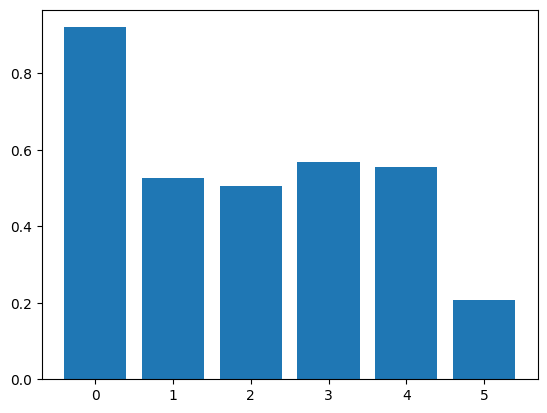

In [29]:
#accuracy bar plot for each category
accuracy = []
for cat in sorted(df["y_true"].round().astype(int).unique()):
    df_cat = df[df["y_true"].round().astype(int) == cat]
    accuracy.append((df_cat["y_true"].round() == df_cat["y_pred"].round()).mean())
plt.bar(sorted(df["y_true"].round().astype(int).unique()), accuracy)

print(accuracy)

In [32]:
from sklearn.metrics import roc_auc_score, root_mean_squared_error, mean_squared_error

Text(0.5, 1.0, 'Mean Squared Error for each week')

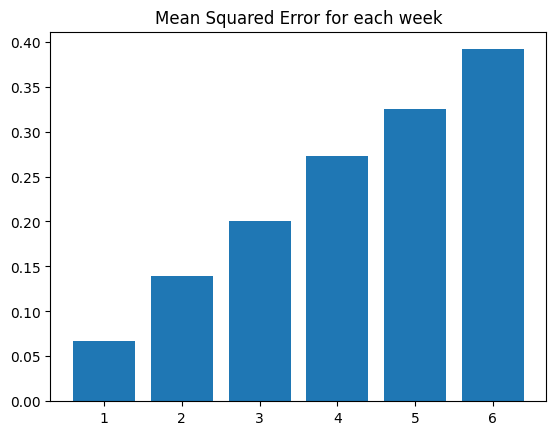

In [33]:
# MAE plot for each week
mse = []
for w in range(6):
    wdf = df[df['week']==w]
    mse.append(mean_squared_error(wdf['y_true'], wdf['y_pred']))
plt.bar(range(1,7), mse)
plt.title("Mean Squared Error for each week")

Text(0.5, 1.0, 'F1 score for each week')

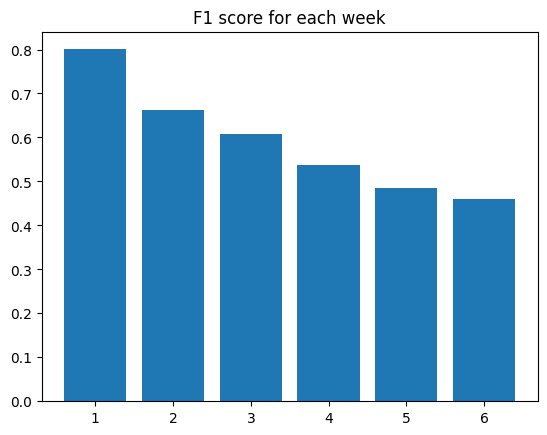

: 

In [34]:
# F1 plot for each week
f1 = []
for w in range(6):
    wdf = df[df['week']==w]
    f1.append(f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro'))
plt.bar(range(1,7), f1)
plt.title("F1 score for each week")

(array([1.000e+00, 1.000e+00, 5.000e+00, 6.000e+00, 4.000e+00, 1.100e+01,
        1.400e+01, 8.000e+00, 2.000e+01, 2.800e+01, 3.900e+01, 6.000e+01,
        1.120e+02, 1.320e+02, 1.590e+02, 2.790e+02, 6.540e+02, 1.740e+03,
        5.748e+03, 1.648e+03, 8.840e+02, 7.310e+02, 6.200e+02, 5.640e+02,
        4.910e+02, 3.420e+02, 1.650e+02, 1.120e+02, 7.300e+01, 6.900e+01,
        5.400e+01, 4.200e+01, 1.900e+01, 1.100e+01, 3.000e+00, 1.000e+01,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([-2.83888745e+00, -2.68943896e+00, -2.53999046e+00, -2.39054196e+00,
        -2.24109347e+00, -2.09164497e+00, -1.94219647e+00, -1.79274798e+00,
        -1.64329948e+00, -1.49385098e+00, -1.34440249e+00, -1.19495399e+00,
        -1.04550549e+00, -8.96056998e-01, -7.46608502e-01, -5.97160005e-01,
        -4.47711509e-01, -2.98263012e-01, -1.48814516e-01,  6.33980856e-04,
         1.50082477e-01,  2.99530974e-01,  4.48979470e-01,  5.98427967e-01,
         7.47876463e-01,  8.97324960e-01,  1.0

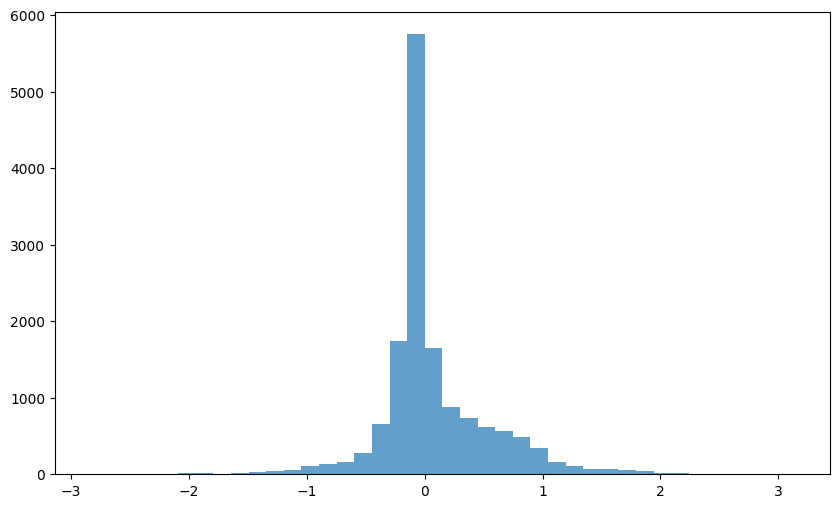

In [30]:
# Error distribution
plt.figure(figsize=(10, 6))
plt.hist(df['y_true'] - df['y_pred'], bins=40, alpha=0.7, label='error')

Text(0, 0.5, 'Residuals')

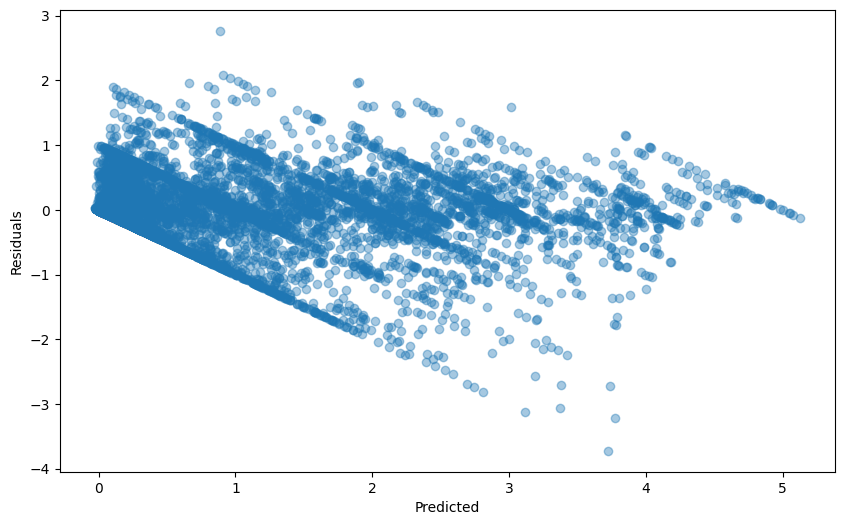

In [30]:
# predicted values vs residuals
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'] - df['y_pred'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("Residuals")

Text(0, 0.5, 'True')

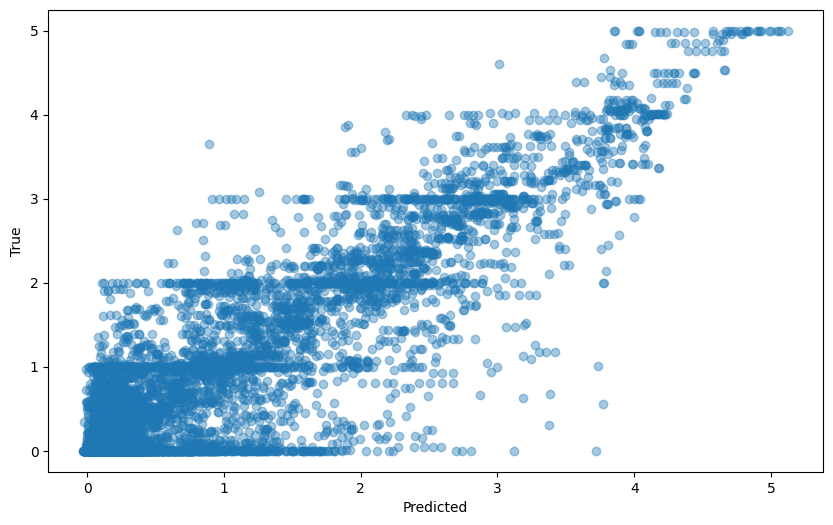

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("True")